In [1]:
import pandas as pd
import math
from datetime import datetime
import shapely.geometry as sg
import shapely.affinity as sa
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import descartes
from matplotlib.patches import Rectangle, Circle
from common import Fonts, Images, NWSL, Colors, add_twitter_handle, add_source

In [2]:
# Read data
df = pd.read_csv("data/cleaned.csv")
df

,date,season,home,away,home_score,away_score
0,2013-04-13,2013,KC,POR,1,1
1,2013-04-14,2013,CHI,RGN,1,1
2,2013-04-14,2013,NJY,WNY,1,0
3,2013-04-14,2013,BOS,WAS,1,1
4,2013-04-20,2013,WAS,WNY,1,1
...,...,...,...,...,...,...
995,2023-04-22,2023,POR,LOU,2,0
996,2023-04-23,2023,KCC,ORL,2,0
997,2023-04-23,2023,LA,SD,0,2
998,2023-04-28,2023,HOU,NC,0,1


In [3]:
# Read standings data
standings = pd.read_csv("data/standings.csv")
standings = standings.set_index(["year", "team"])

def get_position(team, year):
    return standings.loc[year, team]["position"]

In [4]:
# Color helpers

def hex_to_tuple(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)
    
def blend_colors(a, b):
    alpha = 160
    a = hex_to_tuple(a)
    b = hex_to_tuple(b)

    red   = (a[0] * (255 - alpha) + b[0] * alpha) / 255
    green = (a[1] * (255 - alpha) + b[1] * alpha) / 255
    blue  = (a[2] * (255 - alpha) + b[2] * alpha) / 255
    return rgb_to_hex(int(red), int(green), int(blue))

In [5]:
# Name helper
def name(team, year):
    if team == "RGN" and year < 2019:
        return "Seattle Reign"
    elif team == "NJY" and year < 2022:
        return "Sky Blue FC"
    else:
        return NWSL.name(team)

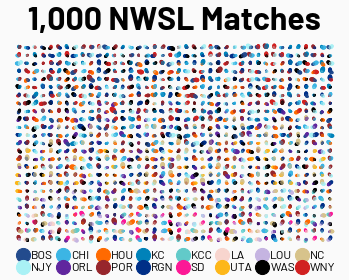

In [6]:
W = 40
H = 25
overlap = 0.08
max_score = max(df["away_score"].max(), df["home_score"].max())

# Setup
plt.rcParams["figure.figsize"] = (12, 8)
fig, ax = plt.subplots()
fig.patch.set_facecolor(Colors.WHITE)


def r(goals):
    return 0.39 * math.sqrt((goals + 1) /(max_score + 1))


if r(0) < overlap:
    print("Overlap is too small!")


def get_ellipse(x, y, r, pos):
    sign = -1 if r < 0 else 1
    a = sg.Point(x + r - overlap * sign, y).buffer(1)
    a = sa.scale(a, abs(r), abs(r) * 0.7)
    a = sa.rotate(a, -90 * sign + 180 * (pos - 1) / 11 * sign, origin=(x, y))
    return a

def rotate_180(ellipse):
    return sa.rotate(ellipse, 180, origin=ellipse.centroid)


def plot_match(ax, i, row):
    x = i % W + 0.5
    y = int(i / W) + 0.5

    a_r = r(row["home_score"])
    b_r = r(row["away_score"])
    a_pos = get_position(row["home"], row["season"])
    b_pos = get_position(row["away"], row["season"])
    a = get_ellipse(x, y, -a_r, a_pos)
    b = get_ellipse(x, y, b_r, b_pos)
    a_color = NWSL.color(row["home"], old=True)
    b_color = NWSL.color(row["away"], old=True)

    ax.add_patch(descartes.PolygonPatch(a, color=a_color))
    ax.add_patch(descartes.PolygonPatch(rotate_180(a), color=a_color))
    
    ax.add_patch(descartes.PolygonPatch(b, color=b_color))
    ax.add_patch(descartes.PolygonPatch(rotate_180(b), color=b_color))
    
    ax.add_patch(
        descartes.PolygonPatch(a.intersection(b), color=blend_colors(a_color, b_color))
    )


demo = False

if demo:
    plot_match(ax, 0, df.iloc[997])
    ax.set_xlim([0, 1])
    ax.set_ylim([1, 0])
    plt.gca().set_aspect("equal")
else:
    for i, row in df.iterrows():
        plot_match(ax, i, row)
    ax.set_xlim([-1, W + 1])
    ax.set_ylim([H + 1, -1])

    # Legend
    teams = df["home"].unique()
    teams.sort()
    for i, team in enumerate(teams):
        x = 1 + (i % 8) * (W / 8)
        y = H + 1.5 + int(i / 8) * 1.5
        ax.text(
            x + 1,
            y + 0.1,
            team,
            ha="left",
            va="center",
            fontproperties=Fonts.BARLOW,
            size=12,
        )
        ax.scatter([x], [y], s=200, color=NWSL.color(team), clip_on=False)

    # Title
    ax.set_title(
        "1,000 NWSL Matches",
        fontproperties=Fonts.BARLOW_BOLD,
        size=32,
        ha="center",
        x=0.5,
        y=1,
    )

    # Twitter logo and username
    # add_twitter_handle(fig, x=0.78, y=0, fs=12, w=0.025)
    # add_source(fig, "nwslR/nwslpy & FBRef", fs=12, x=0.03, y=0)

    ax.axis("off")
    plt.gca().set_aspect("equal")

    plt.savefig("images/1000_print.png", dpi=600, bbox_inches="tight", pad_inches=0.5)

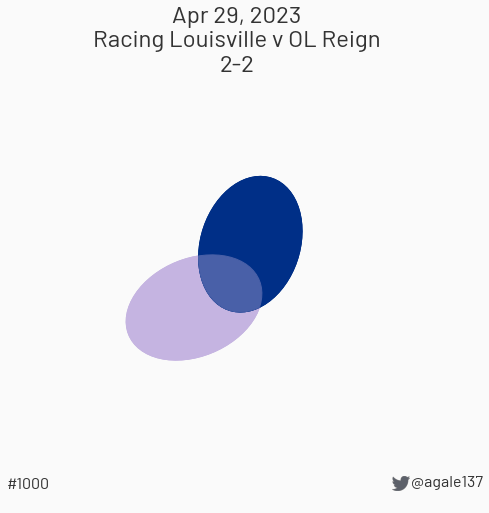

In [7]:
# Build a legend


def plot_single(match_num):

    # Setup
    plt.rcParams["figure.figsize"] = (8, 8)
    fig, ax = plt.subplots()
    fig.patch.set_facecolor(Colors.WHITE)

    plot_match(ax, 0, df.iloc[match_num - 1])
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([1.25, -0.25])

    # Title
    ax.text(
        -0.2,
        1.19,
        "#" + str(match_num),
        fontproperties=Fonts.BARLOW,
        color=Colors.BLACK,
        size=16,
        ha="center",
    )

    match = df.iloc[match_num - 1]

    # Subtitle
    ax.text(
        0.5,
        -0.25,
        datetime.strptime(match["date"], "%Y-%m-%d").strftime("%b %d, %Y")
        + "\n"
        + name(match["home"], match["season"])
        + " v "
        + name(match["away"], match["season"])
        + "\n"
        + str(match["home_score"])
        + "-"
        + str(match["away_score"]),
        fontproperties=Fonts.BARLOW,
        color=Colors.BLACK,
        size=24,
        ha="center",
    )

    add_twitter_handle(fig, x=0.78, y=0.15, fs=16, w=0.028)

    ax.axis("off")
    plt.gca().set_aspect("equal")

    plt.savefig(
        "images/match_" + str(match_num) + ".png",
        dpi=400,
        bbox_inches="tight",
        pad_inches=0.5,
    )
    
plot_single(1000)

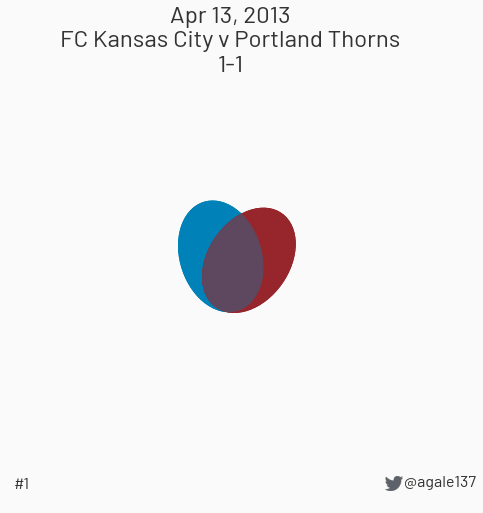

In [8]:
plot_single(1)

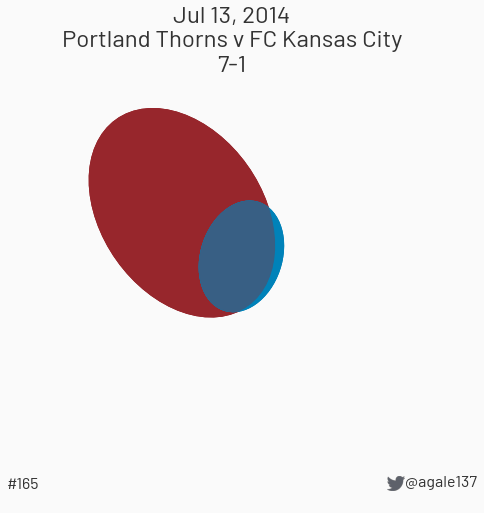

In [9]:
# Largest victories
plot_single(165)

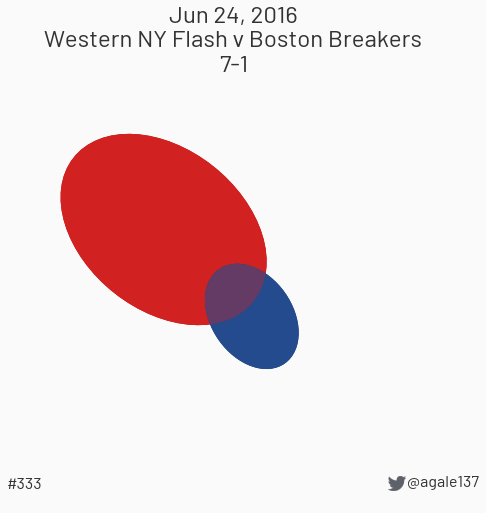

In [10]:
plot_single(333)

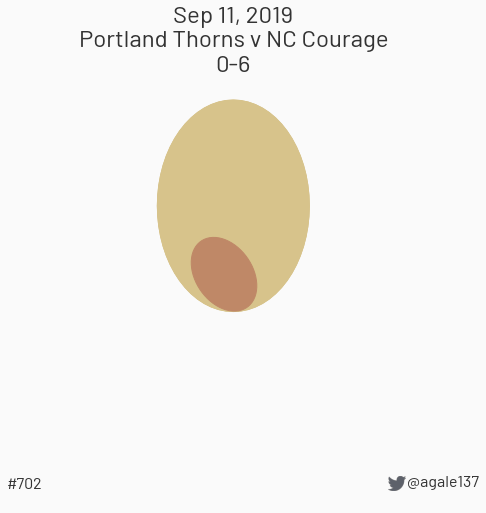

In [11]:
plot_single(702)

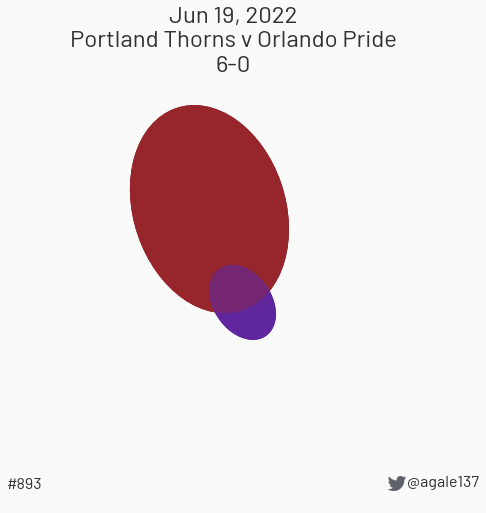

In [12]:
plot_single(893)

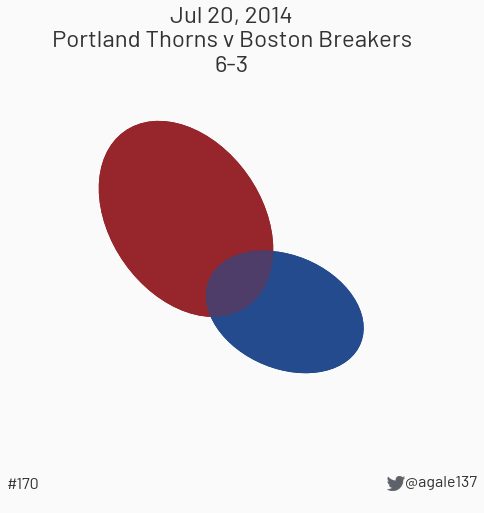

In [13]:
# Most goals scored
plot_single(170)

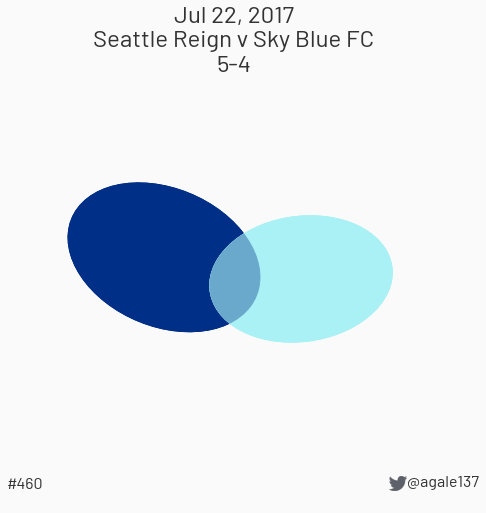

In [14]:
plot_single(460)

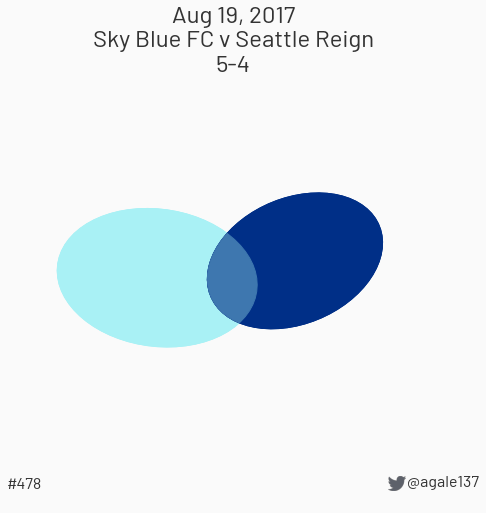

In [15]:
plot_single(478)

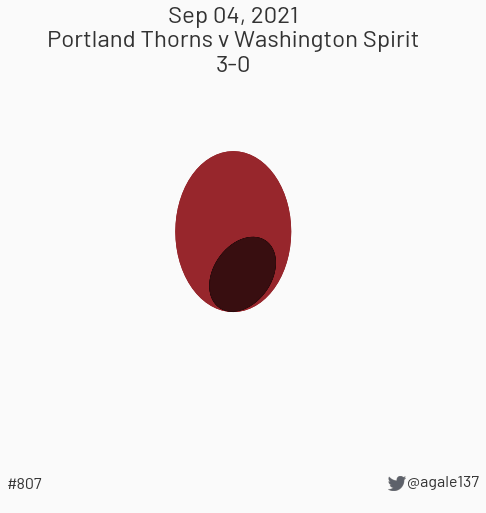

In [17]:
# Skipped game
plot_single(807)

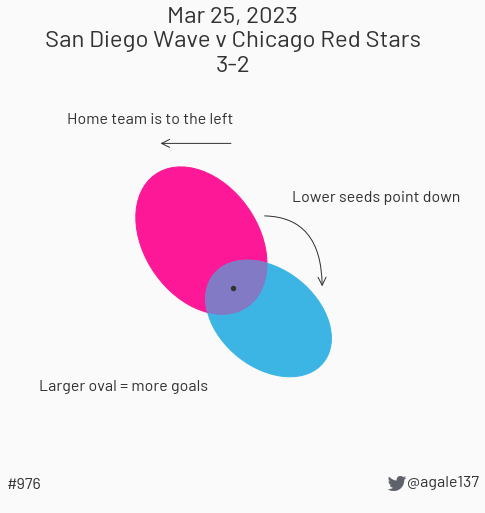

In [16]:
# Legend
match_num = 976

# Setup
plt.rcParams["figure.figsize"] = (8, 8)
fig, ax = plt.subplots()
fig.patch.set_facecolor(Colors.WHITE)

# Plot data
plot_match(ax, 0, df.iloc[match_num - 1])
ax.set_xlim([-0.25, 1.25])
ax.set_ylim([1.25, -0.25])

ax.scatter([0.5], [0.5], s=20, color=Colors.BLACK)

ax.text(
    0.5,
    -0.07,
    "Home team is to the left",
    fontproperties=Fonts.BARLOW,
    color=Colors.BLACK,
    size=16,
    ha="right"
)

ax.text(
    0.7,
    0.2,
    "Lower seeds point down",
    fontproperties=Fonts.BARLOW,
    color=Colors.BLACK,
    size=16,
)

ax.text(
    -0.15,
    0.85,
    "Larger oval = more goals",
    fontproperties=Fonts.BARLOW,
    color=Colors.BLACK,
    size=16,
)

ax.add_patch(
    patches.FancyArrowPatch(
        (0.6, 0.25),
        (0.8, 0.5),
        connectionstyle="angle3,angleA=0,angleB=90",
        arrowstyle="->",
        mutation_scale=20,
        clip_on=False,
        color=Colors.BLACK,
    )
)

# Title
ax.text(
    -0.2,
    1.19,
    "#" + str(match_num),
    fontproperties=Fonts.BARLOW,
    color=Colors.BLACK,
    size=16,
    ha="center",
)

match = df.iloc[match_num - 1]

# Subtitle
ax.text(
    0.5,
    -0.25,
    datetime.strptime(match["date"], "%Y-%m-%d").strftime("%b %d, %Y")
    + "\n"
    + name(match["home"], match["season"])
    + " v "
    + name(match["away"], match["season"])
    + "\n"
    + str(match["home_score"])
    + "-"
    + str(match["away_score"]),
    fontproperties=Fonts.BARLOW,
    color=Colors.BLACK,
    size=24,
    ha="center",
)

ax.add_patch(
        patches.FancyArrowPatch(
            (0.5, 0),
            (0.25, 0),
            arrowstyle="->",
            mutation_scale=20,
            clip_on=False,
            color=Colors.BLACK
        )
    )

add_twitter_handle(fig, x=0.78, y=0.15, fs=16, w=0.028)

ax.axis("off")
plt.gca().set_aspect("equal")

plt.savefig(
    "images/legend_match_" + str(match_num) + ".png",
    dpi=400,
    bbox_inches="tight",
    pad_inches=0.5,
)